<a href="https://colab.research.google.com/github/ecra93/activerecord-postgis-adapter/blob/master/quora_word2vec_custom_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quora Insincere Questions

## Custom Word2Vec Embeddings

## Preprocessing

The preprocessing we'll do here:
* Lower case-ing
* Punctuation removal
* Tokenize (split the sentence into a list of terms)
* Stop word removal

Other things that I haven't tried:
* Stemming
* Semmatization
* Part-of-Speech tagging
* Coreference resolution

In [0]:
import pandas as pd
import nltk
import string

In [2]:
# nltk requires "punkt"
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# read in the training data
df = pd.read_csv("quora/train.csv")
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
def preprocess_raw_sentence(sentence):
  """
  This function performs preprocessing over a single string (sentence) of text.
  Returns the sentence as a Python list of tokens.
  """
  
  # (1) lower case
  sentence = sentence.lower()
  
  # (2) remove punctuation
  sentence = sentence.translate(str.maketrans('', '', string.punctuation))
  
  # (3) tokenize
  tokens = nltk.word_tokenize(sentence)
  
  return tokens

In [0]:
def build_corpus(series):
  """
  Takes a list of sentences (each represented as a string), and transforms the
  sentences into a corpus (a set of preprocessed sentences).
  
  The intention is that this receives df["question_text"], and turns it into
  a list of lists of tokens.
  
  Example output:
    [ ["this", "is", "the", "first", "sentence"],
      ["esta", "es", "la", "segunda", "oracion"] ]
  """
  
  corpus = []
  for raw_sentence in series:
    corpus.append( preprocess_raw_sentence(raw_sentence) )
    
  return corpus

In [0]:
corpus = build_corpus(df["question_text"])

## Training Word2Vec

In [0]:
import numpy as np
from gensim.models import Word2Vec

In [0]:
# insantiate/train the encoder
encoder = Word2Vec(corpus, min_count=1)
encoder.train(corpus, total_examples=len(corpus), epochs=10)

## Encoding the corpus

In [0]:
def encode_sentence(sentence, encoder):
  return np.sum( [encoder.wv[token] for token in sentence], axis=0 )

In [0]:
def encode_corpus(series, encoder):
  return np.array( [encode_sentence(sentence, encoder) for sentence in series] )

In [0]:
encoded_corpus = encode_corpus(corpus, encoder)

## Visualization

In [0]:
from sklearn.decomposition import PCA

In [0]:
# grab training features/labels
train_X = encoded_corpus
train_y = df["target"]
assert(len(train_X) == len(train_y))

In [103]:
# reduce train_X to 3-dims
pca = PCA(n_components=3)
train_X_reduced = pca.fit_transform(train_X, train_y)

def class_to_col(t):
  if t == 1:
    return "r"
  else:
    return "b"

colours = [ class_to_col(t) for t in train_y ]
pca.explained_variance_ratio_

array([0.7303902 , 0.11292092, 0.05938605], dtype=float32)

In [0]:
# import matplotlinb
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [93]:
train_X_reduced[:, 0]

array([ -2.6143382,  28.48873  , -10.858125 , ..., -21.00569  ,
       -26.934166 ,  -5.648326 ], dtype=float32)

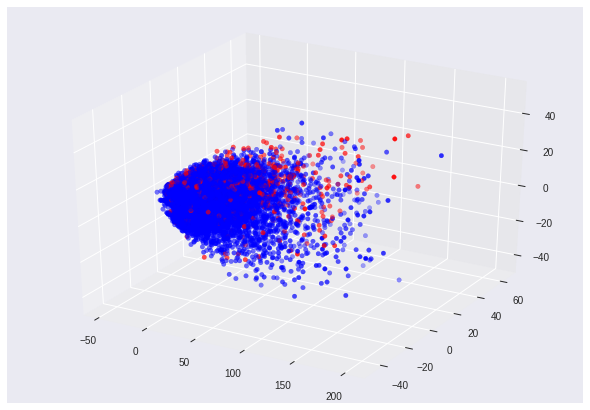

In [104]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(train_X_reduced[:,0], train_X_reduced[:,1], train_X_reduced[:,2], c=colours)
pyplot.show()